In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import keras
import nltk    #Natural language processing tool-kit permet davoir fonction de hahsage etc
nltk.download('stopwords')
  
from nltk.corpus import stopwords                   #Stopwords corpus

from keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
#partie supervisée
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.dummy import DummyClassifier 

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import des données

In [2]:
filename = "./sentiment_labelled_sentences/imdb_labelled.txt"

df = pd.read_csv(filename, sep="\t")
df.columns = ["sentence", "label"]

print("shape", df.shape)

shape (747, 2)


In [3]:
df.head()
# prédire le 0 de 1

,sentence,label
0,Not sure who was more lost - the flat characte...,0
1,Attempting artiness with black & white and cle...,0
2,Very little music or anything to speak of.,0
3,The best scene in the movie was when Gerardo i...,1
4,"The rest of the movie lacks art, charm, meanin...",0


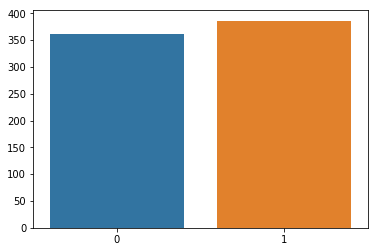

In [4]:
sns.barplot(np.unique(df['label']),df.groupby('label').count().values[:,0])
#verifiactaion du balcement la c'est bon on a l'air davoir autant de 0 que de 1

Avec ce graphique on peut vérifier le bon  balancment des classes. 
On peut voir qu'il ya a peu près autant de '0' que de '1' donc les classes sont bien équilibrées.

## Bag of words 

### Sur un sous-jeu de données

On va d'abord étudier un sous jeu de données. Prenons les 10 premières phrases.

In [5]:
X_sub = df['sentence'][0:10]
# on prend un sous jeu de donnée avec les 10 premières phrases

In [6]:
X_sub

0    Not sure who was more lost - the flat characte...
1    Attempting artiness with black & white and cle...
2         Very little music or anything to speak of.  
3    The best scene in the movie was when Gerardo i...
4    The rest of the movie lacks art, charm, meanin...
5                                  Wasted two hours.  
6    Saw the movie today and thought it was a good ...
7                                 A bit predictable.  
8    Loved the casting of Jimmy Buffet as the scien...
9                 And those baby owls were adorable.  
Name: sentence, dtype: object

On crée un dictionnaire, puis on compte le nombre d'apparition des mots du dictionnaire dans chaque texte (critique)

In [7]:
count_vect = CountVectorizer()
X_sub_counts = count_vect.fit_transform(X_sub)
dictionary_sub   = count_vect.get_feature_names()
print(dictionary_sub)

['about', 'acting', 'adorable', 'almost', 'and', 'angles', 'anything', 'art', 'artiness', 'as', 'attempting', 'audience', 'baby', 'became', 'because', 'best', 'bit', 'black', 'buffet', 'camera', 'casting', 'characters', 'charm', 'clever', 'disappointed', 'effort', 'emptiness', 'empty', 'even', 'existent', 'find', 'flat', 'for', 'gerardo', 'good', 'guess', 'half', 'head', 'his', 'hours', 'if', 'in', 'is', 'it', 'jimmy', 'keeps', 'kids', 'lacks', 'lines', 'little', 'lost', 'loved', 'meaning', 'messages', 'more', 'movie', 'music', 'nearly', 'non', 'not', 'of', 'or', 'out', 'owls', 'plot', 'poor', 'predictable', 'rest', 'ridiculous', 'running', 'saw', 'scene', 'science', 'song', 'speak', 'sure', 'teacher', 'that', 'the', 'those', 'thought', 'through', 'to', 'today', 'trying', 'two', 'very', 'walked', 'was', 'wasted', 'were', 'when', 'white', 'who', 'whom', 'with', 'works']


Chaque mot apparaissant dans les 10 premièere phrases réapparait ci desssus. 

In [8]:
print(count_vect.vocabulary_.get('who')) # sorte de hashage  et who est transformé en 93

93


On a réalisé une sorte de hashage et le mot 'who' est transformé en un entier qui est 93.

In [9]:
print(X_sub_counts.shape) 
print(X_sub_counts[0])
print(type(X_sub_counts))
# je conserve seulement les endroit non nuls on conserve en mémoire la place des non zeros et leur valur 

(10, 97)
  (0, 62)	1
  (0, 87)	1
  (0, 94)	1
  (0, 60)	1
  (0, 36)	1
  (0, 57)	1
  (0, 11)	1
  (0, 61)	1
  (0, 21)	1
  (0, 31)	1
  (0, 78)	2
  (0, 50)	1
  (0, 54)	1
  (0, 88)	1
  (0, 93)	1
  (0, 75)	1
  (0, 59)	1
<class 'scipy.sparse.csr.csr_matrix'>


On ne conserve que les éléments de type non nuls, les éléments n'appartenant qu'à la classe 1. 

In [10]:
dictionary_sub[11] 

'audience'

Avec le dictionnaire de mots créé on peut ainsi retrouver le 11ème mot du dictionnaire.

In [11]:
print(X_sub_counts.toarray()[0,:])


[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0]


Il y a un mot  qui apparait 2 fois  dans le texte. Il faut maintenant 
connaitre quels sont les mots les plus frequents dans le texte.

In [12]:
word_counts = pd.DataFrame(X_sub_counts.toarray(),columns = dictionary_sub) # construction du dico
word_total_counts = pd.DataFrame()
word_total_counts['count'] = word_counts.sum(axis=0)
word_total_counts['word'] = dictionary_sub

In [13]:
word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]

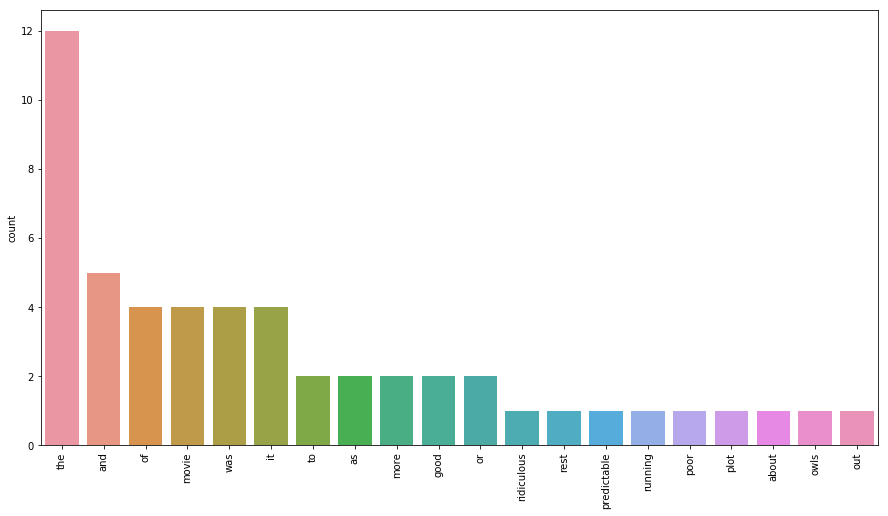

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
plt.xticks(rotation=90,fontsize=10)
plt.show()
# frequence movie pas mot frequent donc n va regler ce pb avec  to as etc on en veut pas 

Avec le diagramme ci-dessus on peut déterminer la fréquence d'utilisation des mots dans le sous jeu de données. Ainsi les mots les plus fréquemment utilisés sont les articles 'the', 'and', 'of'. 
Il y a cependant un problème : les mots les plus fréquents sont des mots qui ne nous intéresse pas. 

On définit une fonction qui prend en encapsule ce qui précède

In [15]:
def most_frequent_words(count_vect,data):    
    data_counts = count_vect.fit_transform(data)
    dictionary   = count_vect.get_feature_names()
    print("Taille du dictionnaire : ",len(dictionary))
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return {'data_counts' : data_counts, 'word_total_counts' :word_total_counts, 'dictionary' : dictionary}# fonction que fait exactement ce qu'on a fait au dessus

In [16]:
count_vect = CountVectorizer()
X_sub_counts = count_vect.fit_transform(X_sub)

Taille du dictionnaire :  97


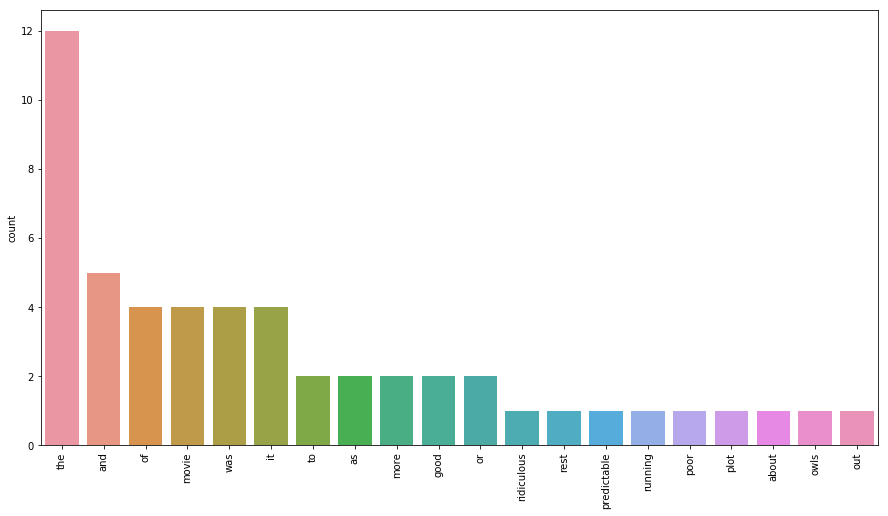

In [17]:
most_frequent_words_sub = most_frequent_words(count_vect,X_sub)# test de la fonctionn donc meme graph quen haut 

### Passage aux données complètes

In [18]:
X = df['sentence']

Taille du dictionnaire :  3044


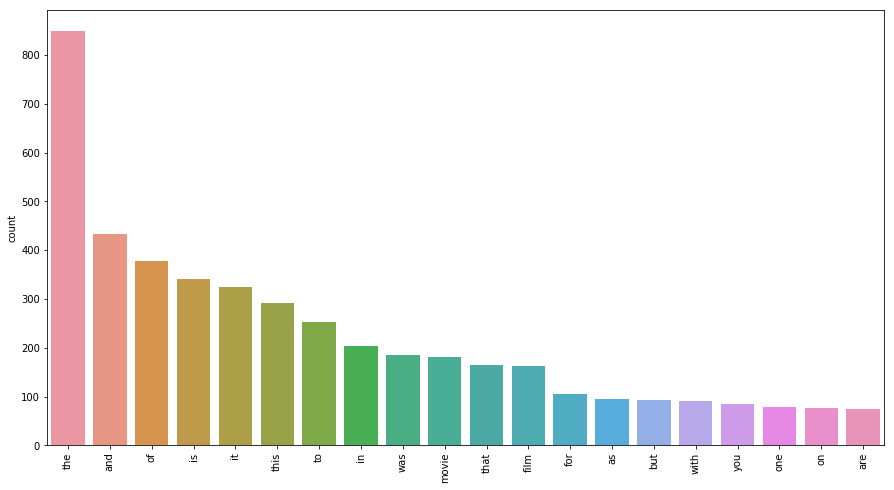

In [19]:
most_frequent_words_tot = most_frequent_words(count_vect,X)
# il ya 3044 mots dans mon dico apparition plus de 800 fois de the ya dess mots trop frequent dont on sen fout 

Avec les données complètes on a toujours le même problème, les mots les plus fréquents sont des mots qui ne nous apportent aucunes informations sur les sentiments  bon ou négatifs des commentaires.

## Préparation des données

### Miniscules UTF-8 sans ponctuation

Toujours vérifier que les mots sont en minuscule, qu'il n'a pas de signe de ponctuation, etc

### Stopwords
On définit un ensemble de mots ( articles , déterminant, pronoms, prépositions, etc...)

In [20]:
stop = set(stopwords.words('english')) 
print(stop)
#tous les mots anglais considérés comme étant non informatif pas classé par ordre alphabetique 

{'as', 'mustn', "wasn't", 'my', 'it', 'll', 'didn', 'too', 'haven', "aren't", 'all', "that'll", 'nor', 'wasn', 're', 'there', 'through', 'himself', 'he', 'same', 'its', 'him', 'been', 'them', 'had', 'those', 'themselves', 'very', 'no', 'hadn', 'am', 't', 'ours', 'into', 'ourselves', 'myself', 'off', 'are', "isn't", "shouldn't", "you'll", 'y', 'will', 'how', "you'd", 'on', 'once', 'which', 'an', 'then', "don't", 'other', 'yours', 'yourself', 'for', 'doesn', 'from', 'or', 'both', 'up', 'were', 'most', 'own', 'has', 'to', 'by', 'under', 'her', 'with', 'these', 'that', 'when', 'me', 'having', "couldn't", "should've", 'does', 'only', 'itself', 'a', 'out', 'not', 'mightn', 'before', 'hers', 'she', 'between', 'further', 'isn', 'did', "didn't", 'but', 'they', 'shan', 'each', 'shouldn', 'we', 'doing', 'aren', "shan't", 'is', 'this', "wouldn't", 'won', 'again', 'their', 'theirs', "haven't", 'some', 'being', 'why', 'couldn', 'hasn', 'your', "mightn't", 'what', 'his', 'above', 'now', 've', 'of', '

In [21]:
stop.update({'movie', 'film', 'one', 'movies', 'also', 'story', 'ever', 'made', 'see'})

On ajoute à 'stop' tous les mots "inutiles " du texte.

Taille du dictionnaire :  2904


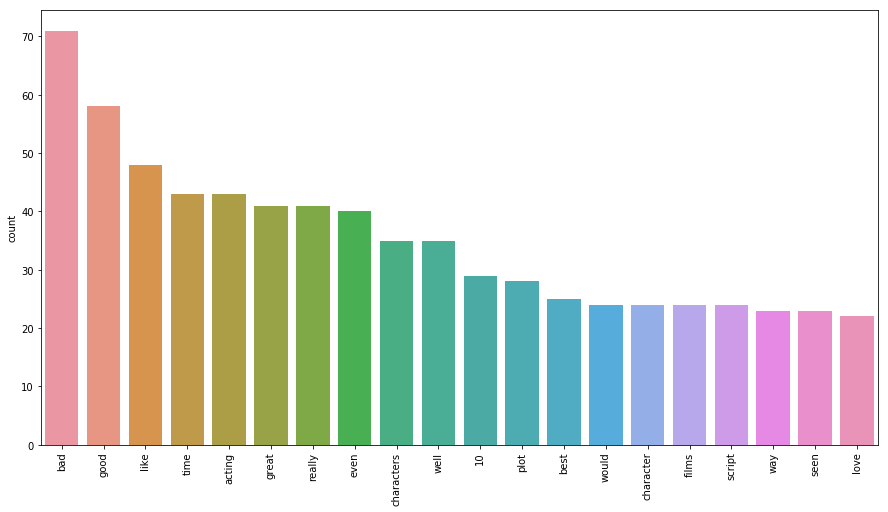

In [22]:
count_vect_sw = CountVectorizer(stop_words=stop)
most_frequent_words_sw = most_frequent_words(count_vect_sw,X)

Après avoir ajouté des mots au stop on les retire du texte et on observe une grande différence : on peut donc dire que le mot le plus fréquent dans le texte est le ot 'bad'. On peut donc évaluer les sentiments majoritaires de toutes les critiques.

### Visualisation du corpus

In [23]:
most_frequent = np.array(most_frequent_words_sw['data_counts'].toarray())
hist = most_frequent / most_frequent.sum(axis=1)[:,None]

In [24]:
hist[np.argsort(df['label']),:]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

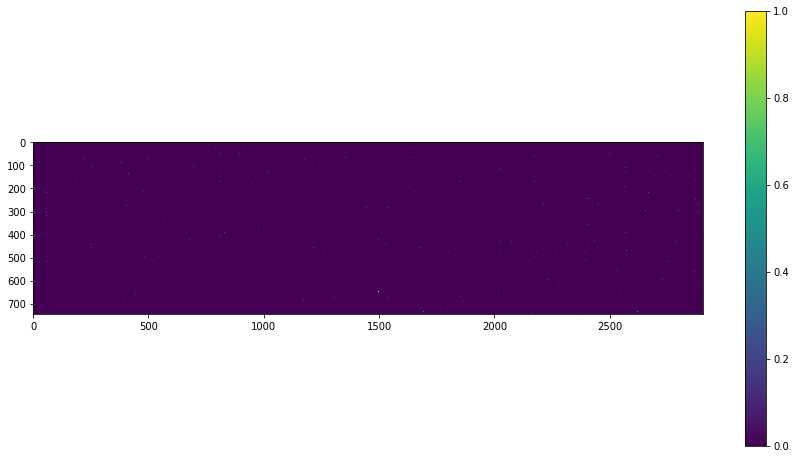

In [25]:
plt.figure(figsize=(15,8))
plt.imshow(hist[np.argsort(df['label']),:])
plt.colorbar() #ici frequence 

### Avec TF_IDF

In [26]:
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [27]:
tf_idf_transf = transformer.fit_transform(most_frequent_words_sw['data_counts'])

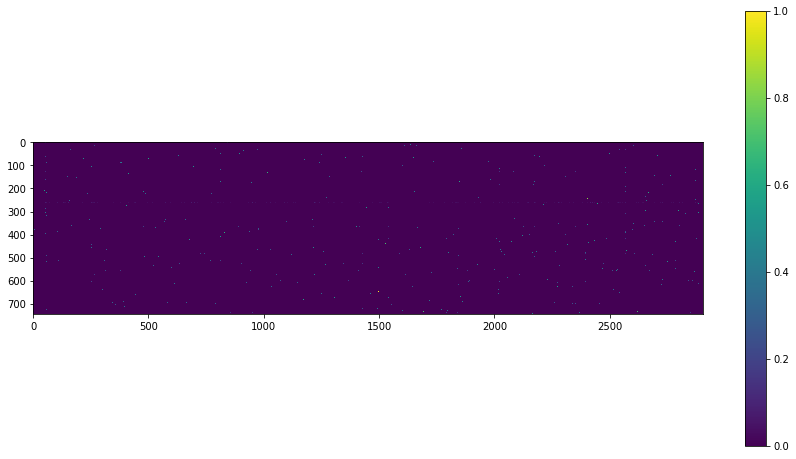

In [28]:
plt.figure(figsize=(15,8))
plt.imshow(tf_idf_transf.toarray()[np.argsort(df['label']),:])
plt.colorbar()

Ici la fréquence des mots est codé par la couleur : plus le mots est utilisé dans le texte plus la couleur est claire.

## Apprentissage supervisé

### Sur les counts

In [62]:
NB_counts = MultinomialNB()
NB_counts.fit(X=most_frequent_words_sw['data_counts'],y=df['label'])
print('Le score de précision est :', accuracy_score(NB_counts.predict(most_frequent_words_sw['data_counts']),df['label']), ',il est très proche de 1 donc cette méthodes est plutot efficace')

Le score de précision est 0.9678714859437751 il est très proche de 1 donc cette méthodes est plutot efficace


### Sur le TF-IDF

In [66]:
NB_tfidf = GaussianNB()
NB_tfidf.fit(X=tf_idf_transf.toarray(),y=df['label'])
print('le score de précision est: ',accuracy_score(NB_tfidf.predict(tf_idf_transf.toarray()),df['label']), ', il est proche de 1 du même ordre que sur les counts')

le score de précision est:  0.9665327978580991 , il est proche de 1 du même ordre que sur les counts


In [31]:
df['prediction_counts'] = NB_counts.predict(most_frequent_words_sw['data_counts'])

In [32]:
df['prediction_tfidf'] = NB_tfidf.predict(tf_idf_transf.toarray())

In [33]:
df[df['prediction_tfidf'] != df['label']]

,sentence,label,prediction_counts,prediction_tfidf
23,Give this one a look.,1,1,0
38,I don't think you will be disappointed.,1,0,0
58,A great film by a great director.,1,1,0
63,10/10,1,1,0
163,Everything from acting to cinematography was s...,1,1,0
250,"I won't say any more - I don't like spoilers, ...",1,1,0
293,But this movie really got to me.,1,1,0
294,See it.,1,1,0
312,The cast is good.,1,1,0
332,the cast was great.,1,1,0


In [34]:
df[df['prediction_counts'] != df['label']]

,sentence,label,prediction_counts,prediction_tfidf
20,If there was ever a movie that needed word-of-...,1,0,1
38,I don't think you will be disappointed.,1,0,0
49,The directing and the cinematography aren't qu...,0,1,0
76,"I saw ""Mirrormask"" last night and it was an un...",0,1,0
123,Highly unrecommended.,0,1,0
131,There were too many close ups.,0,1,0
142,It even has its sweet moments.,1,0,1
235,1/10 - and only because there is no setting fo...,0,1,0
244,The last 15 minutes of movie are also not bad ...,1,0,1
335,but the movie makes a lot of serious mistakes.,0,1,0


In [35]:
NB_logistic = SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)
logistic_fit = NB_logistic.fit(X=tf_idf_transf.toarray(),y=df['label'])
accuracy_score(NB_logistic.predict(tf_idf_transf.toarray()),df['label'])

0.9839357429718876

In [36]:
print("Mots avec le coeff le plus négatif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][0]])
print("Mots avec le coeff le plus positif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][-1]])

Mots avec le coeff le plus négatif :  bad
Mots avec le coeff le plus positif :  wonderful


### Avec une pipeline

In [37]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)),])

In [72]:
text_clf.fit(X,df['label'])#
print('Le score de précision est : ',accuracy_score(text_clf.predict(X),df['label']), 'encore plus efficace que les 2 précédents')

Le score de précision est :  0.9825970548862115 encore plus efficace que les 2 précédents


## Jeu de données complet

Jeu de données de 25 000 critiques de films de IMDB, étiquetées par sentiment (positif / négatif). Les revues ont été prétraitées et chaque critique est codée sous forme d'une séquence d'indice de mots (entiers). Pour plus de commodité, les mots sont indexés par fréquence globale dans l'ensemble de données, de sorte que, par exemple, l'entier "3" code le troisième mot le plus fréquent dans les données. Cela permet des opérations de filtrage rapides telles que: "ne considérez que les 10 000 mots les plus communs, mais éliminez les 20 mots les plus courants".

In [39]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000, index_from=3)

On ne considère que les 10 000 mots les plus courants avec un décalage d'index de mots 3. On charge donc le jeu de donnée en ne gardant que les 10 000 premiers mots et en mettant à 0 le reste. 

On affiche également les valeurs uniques de la classe.

In [40]:
np.unique(y_test)
np.unique(y_train)

array([0, 1], dtype=int64)

Nous pouvons voir que c’est un problème de classification binaire pour les bons et les mauvais sentiments dans les critiques.

### Les textes ont été hashés

In [41]:
X_train[:2]
# 2 premières lignes de données

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [42]:
X_train[5]
# le mot codé 1 est le plus fréquent dans le texte

[1,
 778,
 128,
 74,
 12,
 630,
 163,
 15,
 4,
 1766,
 7982,
 1051,
 2,
 32,
 85,
 156,
 45,
 40,
 148,
 139,
 121,
 664,
 665,
 10,
 10,
 1361,
 173,
 4,
 749,
 2,
 16,
 3804,
 8,
 4,
 226,
 65,
 12,
 43,
 127,
 24,
 2,
 10,
 10]

Dans le 6ème texte le mot le plus fréquement utilisé est le mot codé '1'.

### On essaie de reconstruire le 6-ième texte

In [43]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    print(listOfKeys)

In [44]:
getKeysByValue(imdb.get_word_index(), 9)

['it']


In [45]:
for word_num in X_train[5]:
    if not getKeysByValue(imdb.get_word_index(),word_num) in stop :
        stop.update(str(getKeysByValue(imdb.get_word_index(),word_num)))

['the']
['the']
['effort']
['effort']
['still']
['still']
['been']
['been']
['that']
['that']
['usually']
['usually']
['makes']
['makes']
['for']
['for']
['of']
['of']
['finished']
['finished']
['sucking']
['sucking']
['ended']
['ended']
['and']
['and']
['an']
['an']
['because']
['because']
['before']
['before']
['if']
['if']
['just']
['just']
['though']
['though']
['something']
['something']
['know']
['know']
['novel']
['novel']
['female']
['female']
['i']
['i']
['i']
['i']
['slowly']
['slowly']
['lot']
['lot']
['of']
['of']
['above']
['above']
['and']
['and']
['with']
['with']
['connect']
['connect']
['in']
['in']
['of']
['of']
['script']
['script']
['their']
['their']
['that']
['that']
['out']
['out']
['end']
['end']
['his']
['his']
['and']
['and']
['i']
['i']
['i']
['i']


In [ ]:
On étudie le 6è texte où sont codés les mots les plus fréquents du texte.
Ici si le mot n'est pas dans le dictionnaire 'stop' on le rajoute. C4est une façon d'éliminer les stopwords.

In [46]:
frequents_words = set()
for word_num in np.arange(50):
    frequents_words.update(str(getKeysByValue(imdb.get_word_index(),word_num)))

[]
['the']
['and']
['a']
['of']
['to']
['is']
['br']
['in']
['it']
['i']
['this']
['that']
['was']
['as']
['for']
['with']
['movie']
['but']
['film']
['on']
['not']
['you']
['are']
['his']
['have']
['he']
['be']
['one']
['all']
['at']
['by']
['an']
['they']
['who']
['so']
['from']
['like']
['her']
['or']
['just']
['about']
["it's"]
['out']
['has']
['if']
['some']
['there']
['what']
['good']


In [69]:
set(frequents_words)- stop

set()

In [48]:
X_train.shape #taille de X_train

(25000,)

In [51]:
INDEX_FROM = 3
word_to_id = keras.datasets.imdb.get_word_index() 
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[5]))
#while (k<25000):
   # k=+1
    #print(' '.join(id_to_word[id] for id in X_train[k]))

<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br


On a reconstitué le 6 ème texte. 

# CNN pour le  IMDB dataset

In [54]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

## Bloc de jeu de données limité à une longueur maximale de mots

In [55]:
# pad dataset to a maximum review length in words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

## Création du modèle CNN

In [56]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 2,323,605
Trainable params: 2,323,605
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score de précesion : %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 610s - loss: 0.1032 - acc: 0.9656 - val_loss: 0.3375 - val_acc: 0.8790
Epoch 2/2
 - 610s - loss: 0.0453 - acc: 0.9873 - val_loss: 0.4440 - val_acc: 0.8703
Score de précesion : 87.03%
